# Test QAOA with 5 qubit problem on simulator and ibmq_athens.
We will create the ideal circuit with the help of IBMQ by using QAOA in qiskit terra.
Then we transpile the circuit to be used on real device.
For both we will show the measurement outcome.

In [1]:
import warnings
import numpy as np 
from numpy import pi

from qiskit import IBMQ, QuantumRegister, ClassicalRegister, QuantumCircuit, execute, transpile, BasicAer
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq.job import job_monitor
from qiskit.providers.ibmq import least_busy

from utilities.helpers import create_qaoa_meo

In [2]:
qp = QuadraticProgram()
qp.read_from_lp_file("example_5_qubits.lp")
# solve classically as reference
cplex = CplexOptimizer()
print(cplex.solve(qp))
print(qp)

optimal function value: -21.0
optimal value: [1. 0. 1. 1. 0.]
status: SUCCESS
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: test_dense_5

Minimize
 obj: - 4 x_0 + 4 x_1 + 3 x_2 - 2 x_3 + 3 x_4 + [ - 6 x_0^2 - 10 x_0*x_1
      - 8 x_0*x_2 - 8 x_0*x_3 - 6 x_0*x_4 - 6 x_1^2 + 6 x_1*x_2 + 10 x_1*x_3
      - 4 x_1*x_4 + 10 x_2^2 - 18 x_2*x_3 + 4 x_2*x_4 - 6 x_3^2 + 2 x_3*x_4
      - 4 x_4^2 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4
End



In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
shots = 4096

In [4]:
# solve qp with Minimum Eigen Optimizer QAOA and simulator
EVALUATIONS = 20
def qaoa_callback(eval_ct: int, opt_pars: np.ndarray, mean: float, stdev: float) -> None:
    """Print parameterset of last iteration."""
    if eval_ct == EVALUATIONS:
        print("Evaluation count reached ", eval_ct, "with pars:", opt_pars) 
        # Evaluation count reached 20 with pars: [-0.96598411 -0.26119604] original on ibmq_qasm_simulator

qaoa = create_qaoa_meo(max_iter=EVALUATIONS, qaoa_callback=qaoa_callback)
res = qaoa.solve(qp)
res

Evaluation count reached  20 with pars: [-0.10413688  0.45673361]


optimal function value: -21.0
optimal value: [1. 0. 1. 1. 0.]
status: SUCCESS

In [5]:
def create_qaoa_circuit() -> QuantumCircuit:
    """ taken from IBMQ Experience Job ID 608e53f752b7af33fe34177f """
    qreg_q = QuantumRegister(5, 'q')
    circuit = QuantumCircuit(qreg_q)
    circuit.h(qreg_q[0])
    circuit.h(qreg_q[1])
    circuit.cx(qreg_q[1], qreg_q[0])
    circuit.rz(2.4149602828076864, qreg_q[0])
    circuit.cx(qreg_q[1], qreg_q[0])
    circuit.h(qreg_q[2])
    circuit.cx(qreg_q[2], qreg_q[0])
    circuit.rz(1.9319682262461493, qreg_q[0])
    circuit.cx(qreg_q[2], qreg_q[0])
    circuit.cx(qreg_q[2], qreg_q[1])
    circuit.rz(-1.448976169684612, qreg_q[1])
    circuit.cx(qreg_q[2], qreg_q[1])
    circuit.h(qreg_q[3])
    circuit.cx(qreg_q[3], qreg_q[0])
    circuit.rz(1.9319682262461493, qreg_q[0])
    circuit.cx(qreg_q[3], qreg_q[0])
    circuit.cx(qreg_q[3], qreg_q[1])
    circuit.rz(-2.4149602828076864, qreg_q[1])
    circuit.cx(qreg_q[3], qreg_q[1])
    circuit.cx(qreg_q[3], qreg_q[2])
    circuit.rz(4.346928509053836, qreg_q[2])
    circuit.cx(qreg_q[3], qreg_q[2])
    circuit.h(qreg_q[4])
    circuit.cx(qreg_q[4], qreg_q[0])
    circuit.rz(1.448976169684612, qreg_q[0])
    circuit.cx(qreg_q[4], qreg_q[0])
    circuit.u3(0.5223920854580901, 1.5707963267948963, -3.4941874092818432, qreg_q[0])
    circuit.cx(qreg_q[4], qreg_q[1])
    circuit.rz(0.9659841131230746, qreg_q[1])
    circuit.cx(qreg_q[4], qreg_q[1])
    circuit.u3(0.5223920854580902, 1.5707963267948968, -0.12182015711028482, qreg_q[1])
    circuit.cx(qreg_q[4], qreg_q[2])
    circuit.rz(-0.9659841131230746, qreg_q[2])
    circuit.cx(qreg_q[4], qreg_q[2])
    circuit.u3(0.5223920854580902, 1.5707963267948966, 2.293140125697402, qreg_q[2])
    circuit.cx(qreg_q[4], qreg_q[3])
    circuit.rz(-0.4829920565615373, qreg_q[3])
    circuit.cx(qreg_q[4], qreg_q[3])
    circuit.u3(0.5223920854580901, 1.5707963267948968, 2.7847093260181426, qreg_q[3])
    circuit.rx(-0.5223920854580901, qreg_q[4])
    circuit.measure_all()
    return circuit

In [7]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
circuit = create_qaoa_circuit()
job = execute(circuit, BasicAer.get_backend('qasm_simulator'), shots=shots)
counts = job.result().get_counts()
plot_histogram(counts)

Job Status: job has successfully run                         


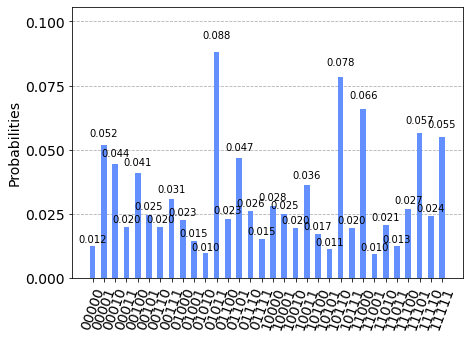

In [6]:
backend = provider.get_backend("ibmq_athens") 
job = execute(circuit, backend, shots=shots, job_name="qaoa_5_real", job_tags=["qaoa", "athens"])
job_monitor(job)

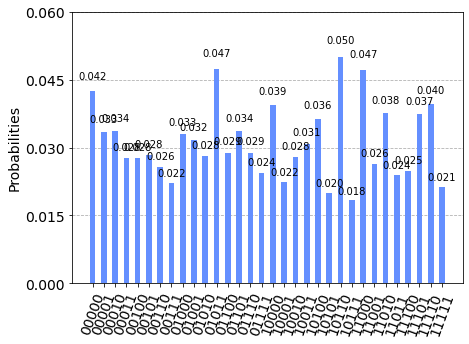

In [8]:
counts = job.result().get_counts()
plot_histogram(counts)